<a href="https://colab.research.google.com/github/CMDRZero/DataScienceFundamentalsClass/blob/main/GranBellU8Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Floods in Mississippi using a BART

Since last unit I tried a GP and spent super long having my model not work I decided to see if I could throw BART at it and get similar or better predictions

### Imports and Installs

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm

In [ ]:
!pip install pymc-bart

In [ ]:
import pymc_bart as pmb

### Getting Data

I got the units this time, Dicharge is $m^3/s$ which is kinda crazy large

In [ ]:
url = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/missriver1.csv'
frame = pd.read_csv(url)

In [ ]:
frame

,year,yrMonth,serMonth,discharge
0,1916,1,1,63.69
1,1916,2,2,81.00
2,1916,3,3,125.42
3,1916,4,4,272.29
4,1916,5,5,427.68
...,...,...,...,...
871,1988,8,872,82.75
872,1988,9,873,57.26
873,1988,10,874,36.00
874,1988,11,875,63.25


### Visualizations of Data

Since our data has a wierd tail shape, I'll plot the log of it to see if its more normal since BART likes more normal distributions

(array([ 10.,   9.,  18.,  47., 140., 272., 197.,  81.,  77.,  25.]),
 array([1.42551507, 1.96065531, 2.49579554, 3.03093577, 3.566076  ,
        4.10121624, 4.63635647, 5.1714967 , 5.70663693, 6.24177717,
        6.7769174 ]),
 <BarContainer object of 10 artists>)

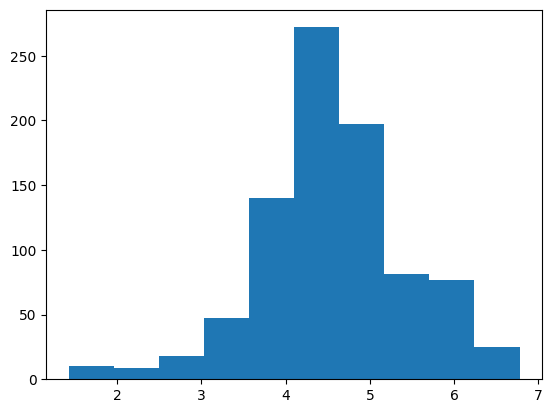

In [ ]:
plt.hist(np.log(frame.discharge))

And below is the plot of discharge vs time

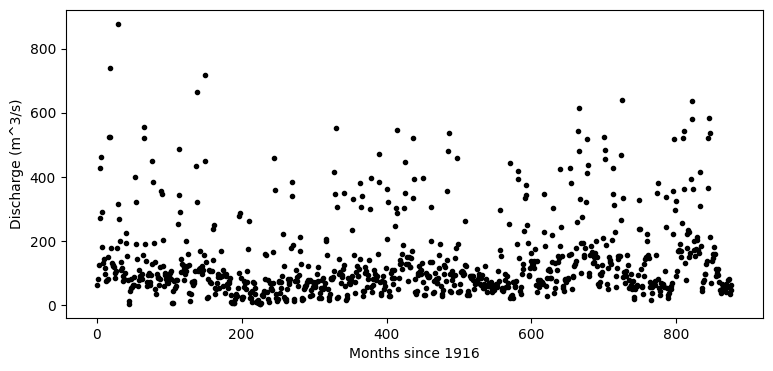

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()

ax.plot(frame.serMonth.values, frame.discharge.values, ".k")
ax.set_xlabel("Months since 1916")
ax.set_ylabel("Discharge (m^3/s)");

And now logarithmic discharge which as we can see clearly shows flucations better

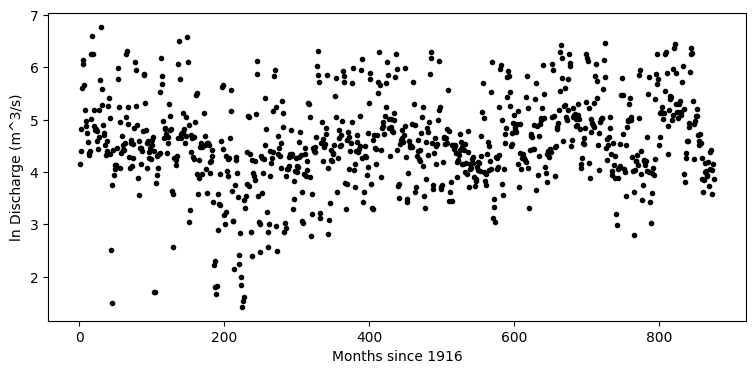

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()

ax.plot(frame.serMonth.values, np.log(frame.discharge.values), ".k")
ax.set_xlabel("Months since 1916")
ax.set_ylabel("ln Discharge (m^3/s)");

Additionally we can see month by month flucations here when we stack the years ontop of each other

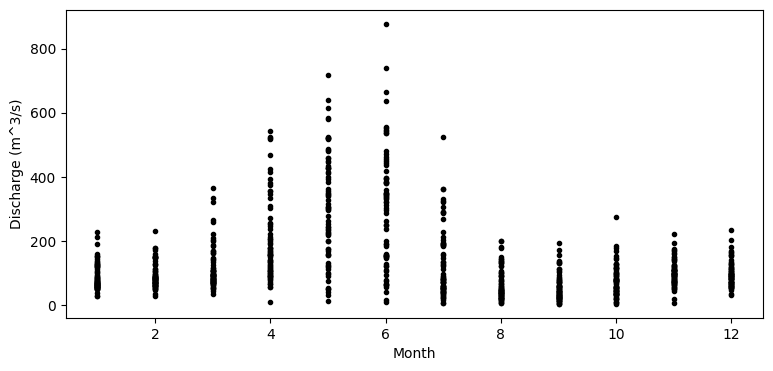

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()

ax.plot(frame.yrMonth.values, frame.discharge.values, ".k")
ax.set_xlabel("Month")
ax.set_ylabel("Discharge (m^3/s)");

### Common features for all models

In [ ]:
#frame['lnDis'] = np.log(frame.discharge)
import arviz as az

Since we want to express that monthly variation is cyclical, I'll remake our month variable into a circle using two coordinates and train it on both year and circle point

In [ ]:
frame['sin_m'] = np.sin(frame.yrMonth / 12 * 2 * np.pi)
frame['cos_m'] = np.cos(frame.yrMonth / 12 * 2 * np.pi)

This is just a total count of years which matters for some of the visualizations

In [ ]:
l = frame['discharge'].shape[0] // 12

And this function lets us map year into tube coordinates

In [ ]:
def ConvertYear(yr):
  return pd.DataFrame({'sin_m': np.sin(yr * 2 * np.pi), 'cos_m': np.cos(yr * 2 * np.pi), 'serMonth': 12*(yr-1916)})

### Circle Model

Define our inputs as just circle, no year right now, we want to see if our model can learn monthly variations.

In [ ]:
Xcyc = frame[['sin_m', 'cos_m']]
Y = frame['discharge']

I take the log and then exp of our model so that we have a nicer output, but so that when we handle it we dont need to exp our data before visualization.

In [ ]:
with pm.Model() as model_cyc:
    s = pm.HalfNormal('s',20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", Xcyc, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata = pm.sample(compute_convergence_checks=False)

Output()

In [ ]:
pm.sample_posterior_predictive(idata,model_cyc, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

That seems, well not great, then again we're intentionally witholding a known parameter, so its struggling.

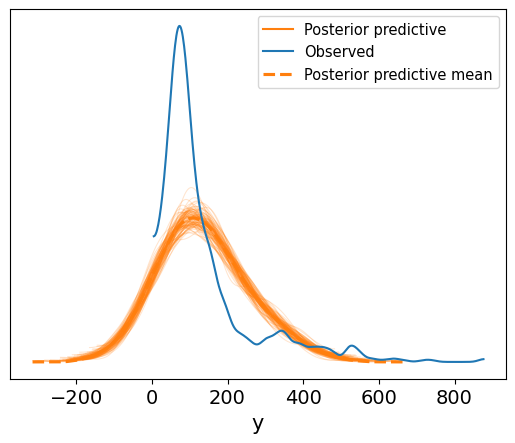

In [ ]:
ax = az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])

I finally figured out a nice way to visualize if its learning our circular values, and thats basically by performing a cdf of each month and comparing to observed

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


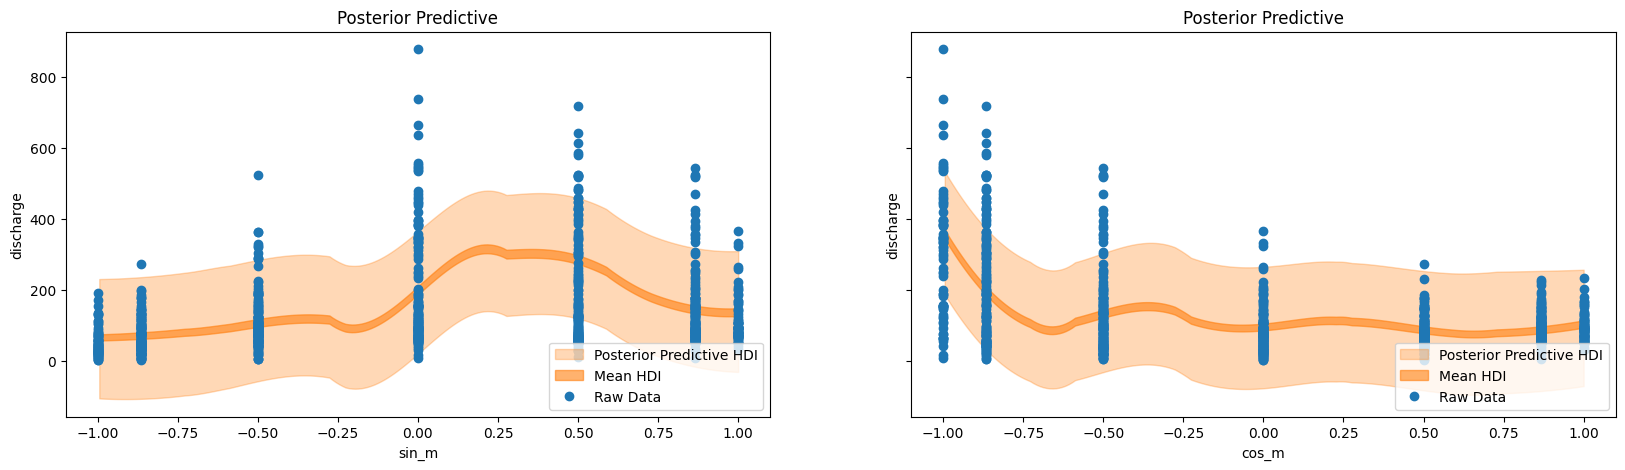

In [ ]:
posterior_mean = idata.posterior["μ"]

μ_hdi = az.hdi(ary=idata, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata, group="posterior_predictive", var_names=["y"]
).T


lats = ['sin_m', 'cos_m']

idx = np.argsort(Xcyc)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(20, 5))

for ax, lat in zip([ax1, ax2], lats):
  az.plot_hdi(
      x=Xcyc[lat],
      y=pps,
      ax=ax,
      hdi_prob=0.93,
      fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
  )

  az.plot_hdi(
      x=Xcyc[lat],
      y=posterior_mean,
      ax=ax,
      hdi_prob=0.74,
      fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
  )
  ax.plot(frame[lat], frame["discharge"], "o", c="C0", label="Raw Data")
  ax.legend(loc="lower right")
  ax.set(
      title="Posterior Predictive",
      xlabel=lat,
      ylabel="discharge",
  );

These are kind of hard to analyze since our parameters arent normal features, but rather custom made. So We'll neeed to make our own visualiztion if we want this to work.

In [ ]:
pred = np.array(idata.posterior_predictive.to_dataarray())[0]
pred.shape

(2, 1000, 876)

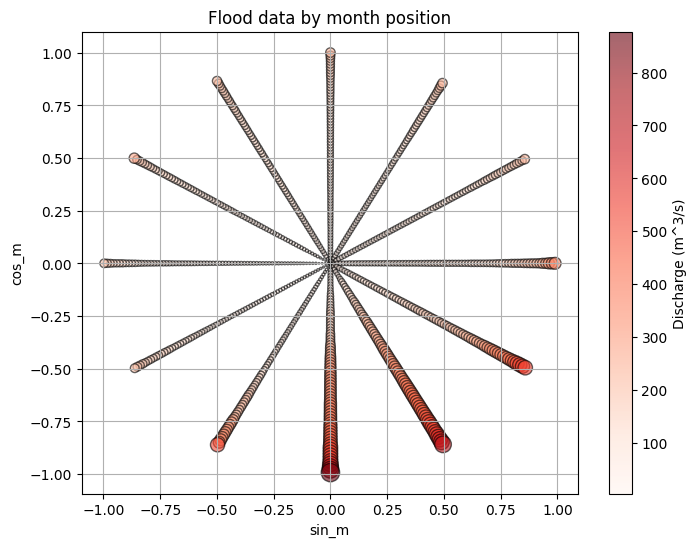

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
k = np.linspace(0, 1, pred.shape[-1])

preds = np.array(frame['discharge']).reshape(l, 12)
preds = np.sort(preds, axis = 0)
preds = preds.flatten()

plt.scatter(k*frame['sin_m'], k*frame['cos_m'], s=preds/5, alpha=0.6, c=preds, cmap='Reds', edgecolors="black")
#plt.scatter(k*frame['sin_m'], k*frame['cos_m'], s=frame['discharge']/5, alpha=0.6, c=frame['discharge'], cmap='Reds', edgecolors="black")
plt.colorbar(label="Discharge (m^3/s)")
plt.xlabel("sin_m")
plt.ylabel("cos_m")
plt.title("Flood data by month position")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


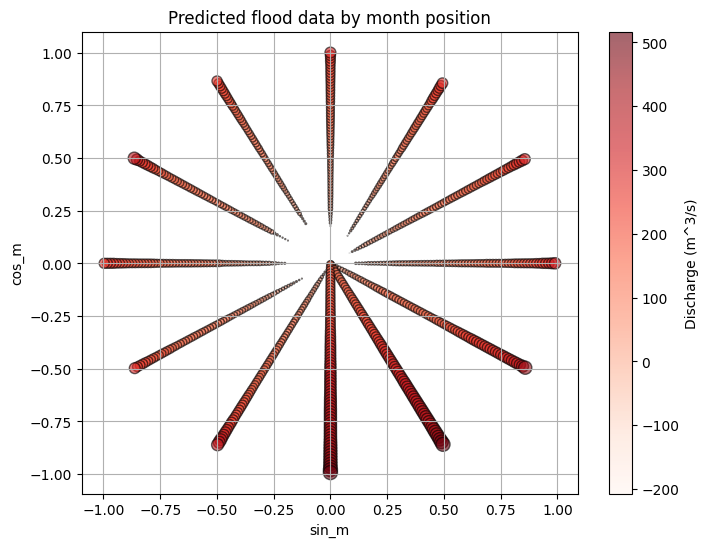

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
k = np.linspace(0, 1, pred.shape[-1])

preds = pred[0][0].reshape(l, 12)
preds = np.sort(preds, axis = 0)
preds = preds.flatten()

plt.scatter(k*frame['sin_m'], k*frame['cos_m'], s=preds/5, alpha=0.6, c=preds, cmap='Reds', edgecolors="black")
plt.colorbar(label="Discharge (m^3/s)")
plt.xlabel("sin_m")
plt.ylabel("cos_m")
plt.title("Predicted flood data by month position")
plt.grid(True)
plt.show()

Whats the conclusion? That it doesnt do too great. It gets the idea, but actually struggles in implementing it in that it way undersells the monthly lows and in general doesnt predict any month too well

### Tiny interlude abt bug fix

```py
with pm.Model() as model_tube:
    s = pm.HalfNormal('s',20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", Xtube, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_tube = pm.sample(compute_convergence_checks=False)
  ```

This code has a sublte ish bug and that made the original version matches a normal to our data which can only be posative. I tried to rememdy this with my logarithms, but neglected to exp it as the last step, so it kept predicting negative values which doesnt make sense.

### Tube Model

Dont run this, for some reason it crashes the runtime and you have to reinstall it and delete everything

In [ ]:
Xtube = frame[['sin_m', 'cos_m', 'serMonth']]
Y = frame['discharge']

In [ ]:
with pm.Model() as model_tube:
    s = pm.HalfNormal('s',1) #sigma = 1 is a blind guess
    μ = pmb.BART("μ", Xtube, np.log(Y), m=50) #log around Y
    y_ = pm.Normal("y_", mu=μ, sigma=s,  observed=np.log(Y)) #likelihood
    y = pm.Deterministic("y",pm.math.exp(y_)) #exp it all once BART is done
    idata_tube = pm.sample(compute_convergence_checks=False)

Output()

In [ ]:
pm.sample_posterior_predictive(idata_tube,model_tube, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_'>

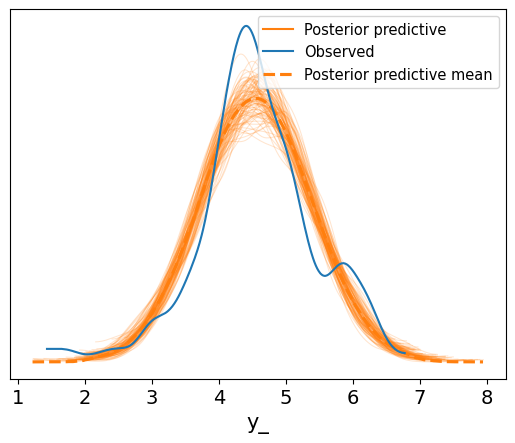

In [ ]:
az.plot_ppc(idata_tube, num_pp_samples=100, colors=["C1", "C0", "C1"])

In [ ]:
#pred = np.array(idata_tube.posterior_predictive.to_dataarray())[0] #This keeps crashing the runtime
#pred.shape

In [ ]:
idata_tube.posterior_predictive.to_dataarray()

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
k = np.linspace(0, 1, pred.shape[-1])

preds = np.array(frame['discharge']).reshape(l, 12)
#preds = np.sort(preds, axis = 0)
preds = preds.flatten()

plt.scatter(k*frame['sin_m'], k*frame['cos_m'], s=preds/5, alpha=0.6, c=preds, cmap='Reds', edgecolors="black")
#plt.scatter(k*frame['sin_m'], k*frame['cos_m'], s=frame['discharge']/5, alpha=0.6, c=frame['discharge'], cmap='Reds', edgecolors="black")
plt.colorbar(label="Discharge (m^3/s)")
plt.xlabel("sin_m")
plt.ylabel("cos_m")
plt.title("Predicted flood data")
plt.grid(True)
plt.show()

NameError: name 'pred' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
k = np.linspace(0, 1, pred.shape[-1])

preds = pred[0][0].reshape(l, 12)
#preds = np.sort(preds, axis = 0)
preds = preds.flatten()

plt.scatter(k*frame['sin_m'], k*frame['cos_m'], s=preds/5, alpha=0.6, c=preds, cmap='Reds', edgecolors="black")
plt.colorbar(label="Number of Trips")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Total Bike Departures Per Station")
plt.grid(True)
plt.show()

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()

ax.plot(frame.serMonth.values, frame.discharge.values, ".k")
ax.plot(frame.serMonth.values, pred[0][0], ".r")
#ax.set_ylim(0, 1000)
ax.set_xlabel("Months since 1916")
ax.set_ylabel("ln CO2 (ppm)");

### Tube Model (That doesnt crash the runtime????)

In [ ]:
Xtube = frame[['sin_m', 'cos_m', 'serMonth']]
Y = frame['discharge']

In [ ]:
with pm.Model() as model_tube:
    XtubeMut = pm.MutableData("X", Xtube)
    s = pm.HalfNormal('s',3) #sigma = 3 is a blind guess
    μ_ = pmb.BART("μ_", XtubeMut, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_tube = pm.sample(compute_convergence_checks=False, chains=1) #Chains = 1 supposidly lets it do predictions!?!?

/usr/local/lib/python3.11/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

In [ ]:
pm.sample_posterior_predictive(idata_tube,model_tube, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

<Axes: xlabel='y'>

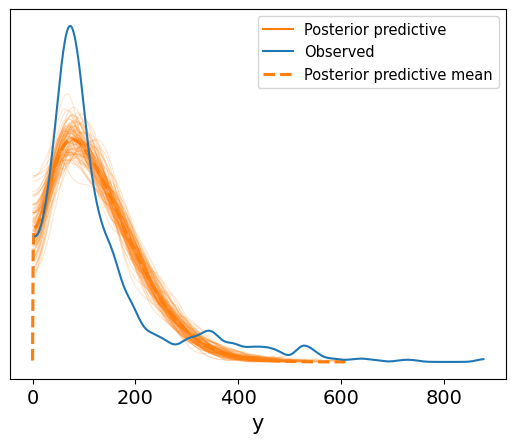

In [ ]:
az.plot_ppc(idata_tube, num_pp_samples=100, colors=["C1", "C0", "C1"])

A much better looking posterior, however as we can see, it struggles to hit the mode as much as it actually does and it ends up failing to fit to the little humps off to the right and the wierd tail shape.

In [ ]:
pred = np.array(idata_tube.posterior_predictive.to_dataarray())[0] #This keeps crashing the runtime
pred.shape

(1, 1000, 876)

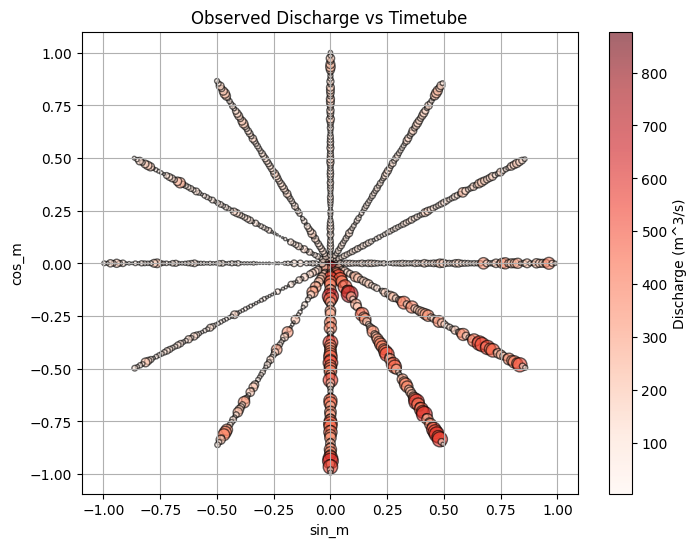

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
k = np.linspace(0, 1, pred.shape[-1])

preds = np.array(frame['discharge']).reshape(l, 12)
#preds = np.sort(preds, axis = 0)
preds = preds.flatten()

plt.scatter(k*frame['sin_m'], k*frame['cos_m'], s=preds/5, alpha=0.6, c=preds, cmap='Reds', edgecolors="black")
#plt.scatter(k*frame['sin_m'], k*frame['cos_m'], s=frame['discharge']/5, alpha=0.6, c=frame['discharge'], cmap='Reds', edgecolors="black")
plt.colorbar(label="Discharge (m^3/s)")
plt.xlabel("sin_m")
plt.ylabel("cos_m")
plt.title("Observed Discharge vs Timetube")
plt.grid(True)
plt.show()

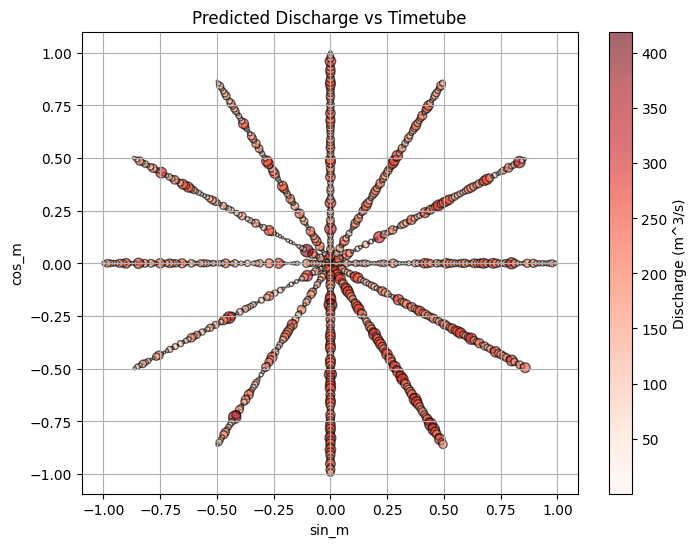

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
k = np.linspace(0, 1, pred.shape[-1])

preds = pred[0][0].reshape(l, 12)
#preds = np.sort(preds, axis = 0)
preds = preds.flatten()

plt.scatter(k*frame['sin_m'], k*frame['cos_m'], s=preds/5, alpha=0.6, c=preds, cmap='Reds', edgecolors="black")
plt.colorbar(label="Discharge (m^3/s)")
plt.xlabel("sin_m")
plt.ylabel("cos_m")
plt.title("Predicted Discharge vs Timetube")
plt.grid(True)
plt.show()

Our model seems to predict with alot less monthly variation and less variation in those months

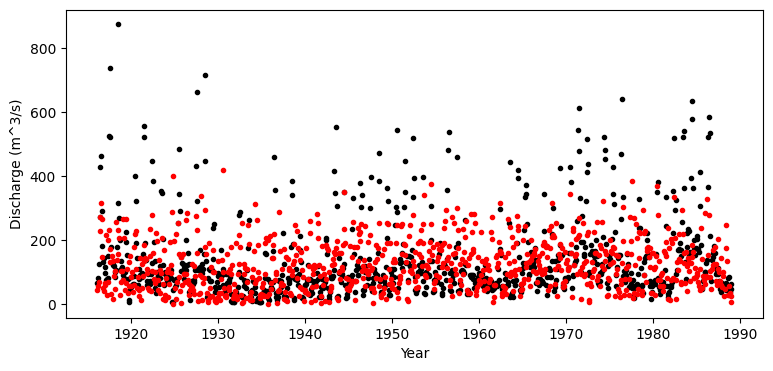

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()

frame['cYr'] = (frame['serMonth'])/12+1916

ax.plot(frame.cYr.values, frame.discharge.values, ".k")
ax.plot(frame.cYr.values, pred[0][0], ".r")
#ax.set_ylim(0, 1000)
ax.set_xlabel("Year")
ax.set_ylabel("Discharge (m^3/s)");

We can see the predicted points (red) seem to just be the inside subset of the total points

array([<Axes: xlabel='sin_m'>, <Axes: xlabel='cos_m'>,
       <Axes: xlabel='serMonth'>], dtype=object)

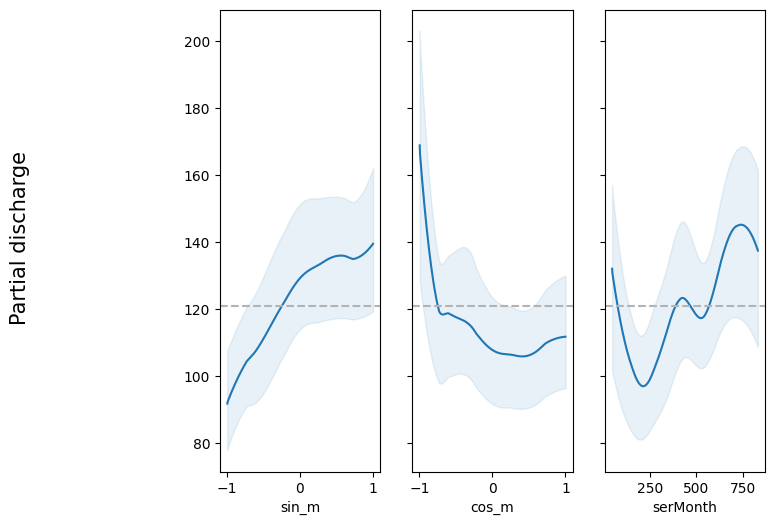

In [ ]:
pmb.plot_pdp(model_tube.μ_, Xtube, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

It is nice to see in our pdp that serMonth has some trend because this is our discharge attributable to global variation

array([<Axes: xlabel='sin_m'>, <Axes: xlabel='cos_m'>,
       <Axes: xlabel='serMonth'>], dtype=object)

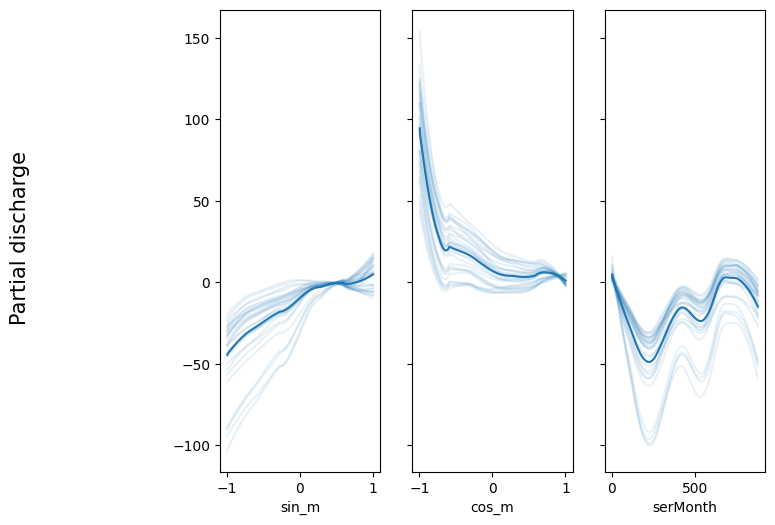

In [ ]:
pmb.plot_ice(model_tube.μ_, Xtube, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

Looking at our Ice plots however, we see our model is pretty much struggling, and that in general its not confident at just about any values except for very speific times (early years), and select poisiotn in the month wheel.

In [ ]:
nys = ConvertYear(np.arange(1916, (1989-1916)*2+1916, 1/6))
with model_tube:
    XtubeMut.set_value(nys)
    #XtubeMut.set_value(ConvertYear(np.arange(1916, 1989, 1/12)))
    predictions = pm.sample_posterior_predictive(trace=idata_tube, predictions = True).to_dataframe()

Output()

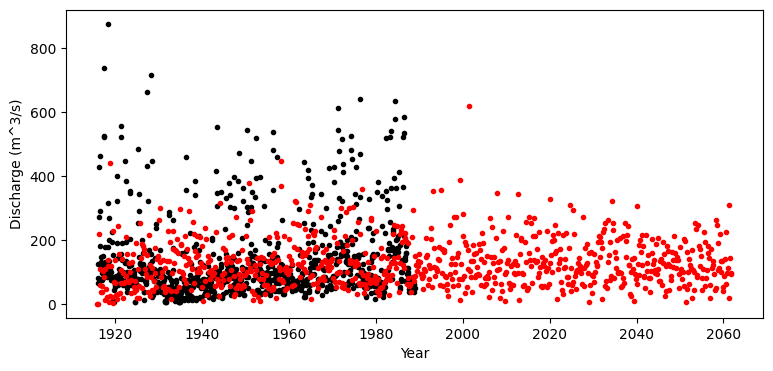

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()

nys['year'] = nys['serMonth']/12+1916

ax.plot(frame.cYr.values, frame.discharge.values, ".k")
ax.plot(nys.year, np.array(predictions)[0][:876], ".r")
#ax.set_ylim(0, 1000)
ax.set_xlabel("Year")
ax.set_ylabel("Discharge (m^3/s)");

Our predictions seem fine... Theyre still conservative estimates, but I can see some trends I think, so thats interesting

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


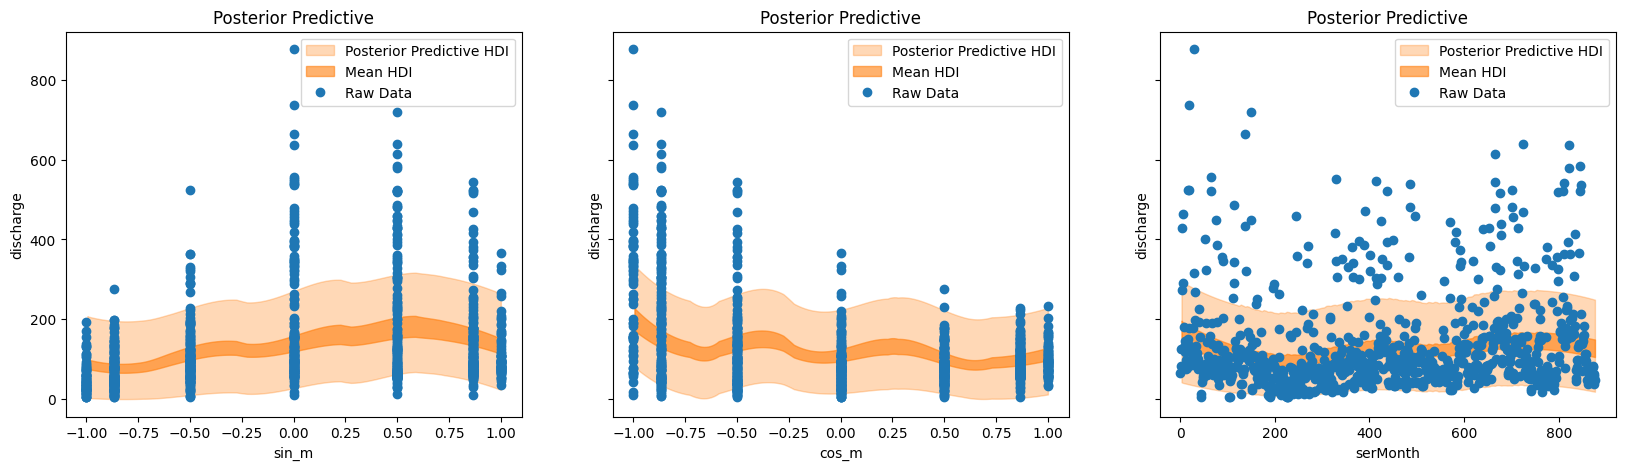

In [ ]:
posterior_mean = idata_tube.posterior["μ"]

μ_hdi = az.hdi(ary=idata_tube, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_tube, group="posterior_predictive", var_names=["y"]
).T


lats = ['sin_m', 'cos_m', 'serMonth']

idx = np.argsort(Xtube)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize=(20, 5))

for ax, lat in zip([ax1, ax2, ax3], lats):
  az.plot_hdi(
      x=Xtube[lat],
      y=pps,
      ax=ax,
      hdi_prob=0.93,
      fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
  )

  az.plot_hdi(
      x=Xtube[lat],
      y=posterior_mean,
      ax=ax,
      hdi_prob=0.74,
      fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
  )
  ax.plot(frame[lat], frame["discharge"], "o", c="C0", label="Raw Data")
  ax.legend(loc="upper right")
  ax.set(
      title="Posterior Predictive",
      xlabel=lat,
      ylabel="discharge",
  );

We can see it better here, but there is some global trends going on, even if our HDI is still very narrow

### Non-Tube Model?

My last idea is to see if BART can predict without our time tube well, I dont think it will, but always test your assumptions.

In [ ]:
Xlin = frame[['yrMonth', 'serMonth']]
Y = frame['discharge']

In [ ]:
with pm.Model() as model_lin:
    XtubeMut = pm.MutableData("X", Xlin)

    s = pm.HalfNormal('s',3) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", XtubeMut, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_lin = pm.sample(compute_convergence_checks=False, chains=1) #Chains = 1 supposidly lets it do predictions!?!?

/usr/local/lib/python3.11/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

In [ ]:
pm.sample_posterior_predictive(idata_lin,model_lin, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

<Axes: xlabel='y'>

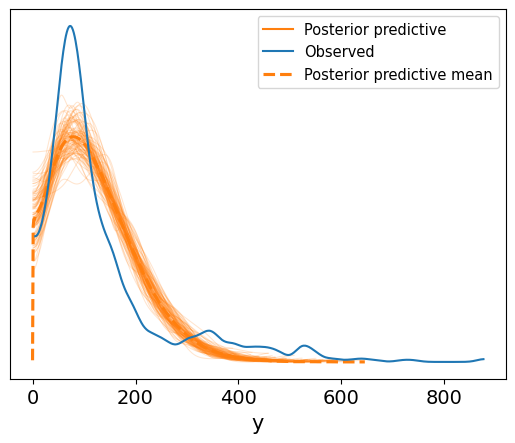

In [ ]:
az.plot_ppc(idata_lin, num_pp_samples=100, colors=["C1", "C0", "C1"])

This looks very similar so no judgement yet

In [ ]:
pred = np.array(idata_lin.posterior_predictive.to_dataarray())[0] #This keeps crashing the runtime
pred.shape

(1, 1000, 876)

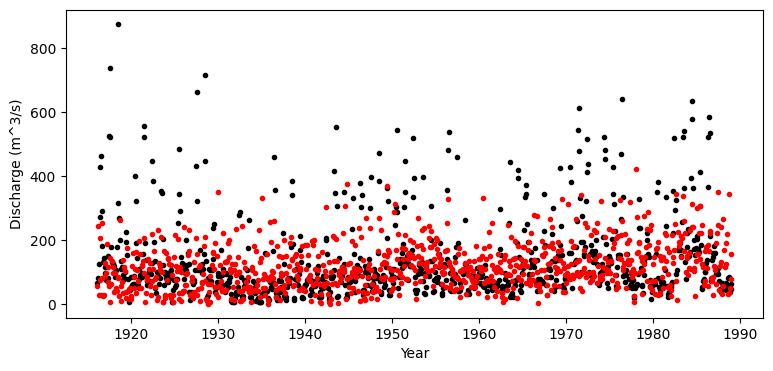

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()

frame['cYr'] = (frame['serMonth'])/12+1916

ax.plot(frame.cYr.values, frame.discharge.values, ".k")
ax.plot(frame.cYr.values, pred[0][0], ".r")
#ax.set_ylim(0, 1000)
ax.set_xlabel("Year")
ax.set_ylabel("Discharge (m^3/s)");

This actually looks fine, so we'll keep going

array([<Axes: xlabel='yrMonth'>, <Axes: xlabel='serMonth'>], dtype=object)

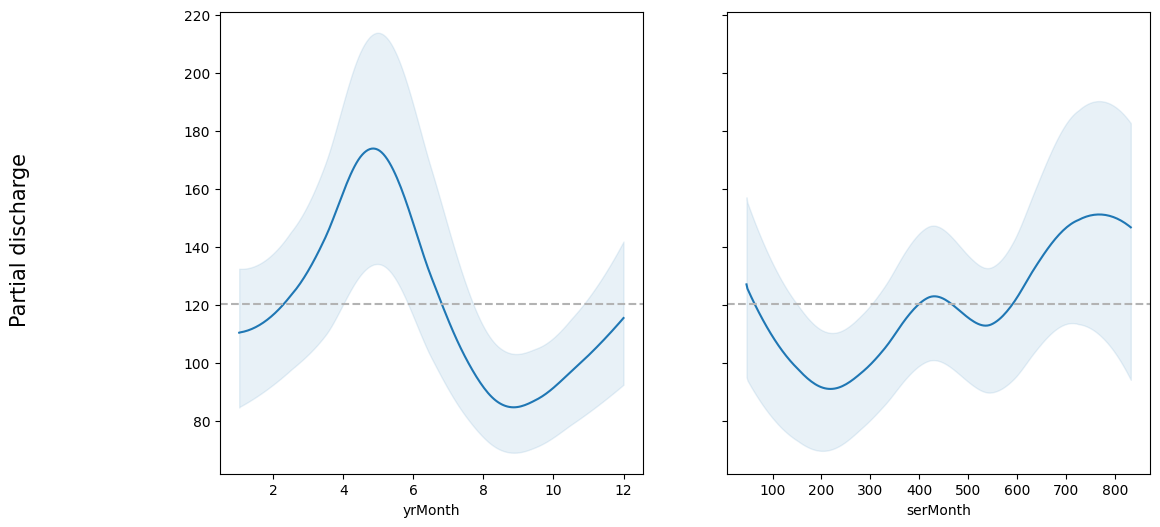

In [ ]:
pmb.plot_pdp(model_lin.μ_, Xlin, Y, grid=(1, 2), func=np.exp, figsize = (12,6))

Damn, ok, it did learn that months wrap. ∃ven tho I didnt tell it to, it seemed to have realized that and consequently figure it out itself.

array([<Axes: xlabel='yrMonth'>, <Axes: xlabel='serMonth'>], dtype=object)

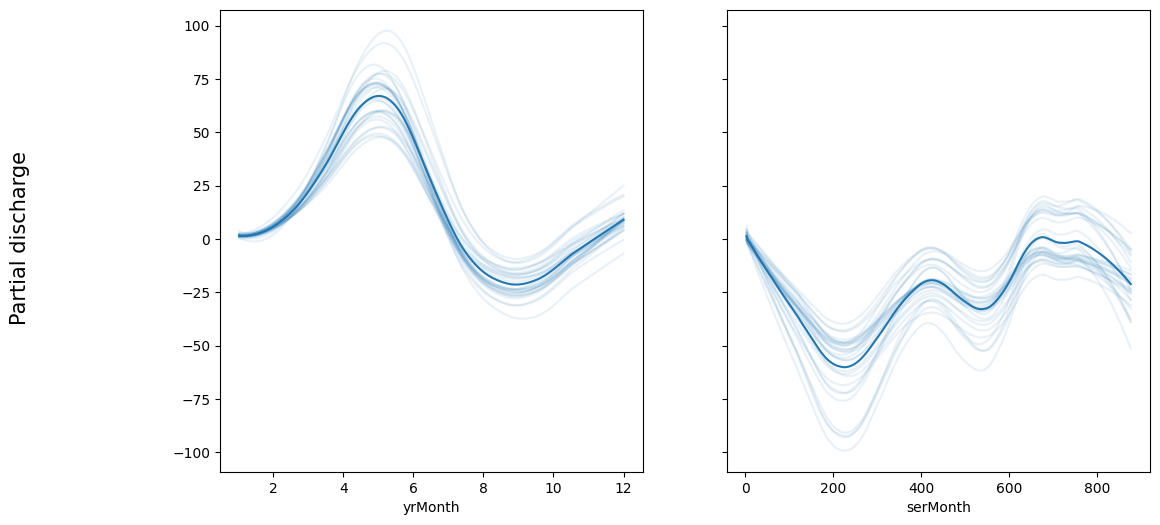

In [ ]:
pmb.plot_ice(model_lin.μ_, Xlin, Y, grid=(1, 2), func=np.exp, figsize = (12,6))

It also seems to have got a better idea of how things fluctuated a result, and we can better analyze the components like what months are flowy / have variation

In [ ]:
nys = ConvertYear(np.arange(1916, (1989-1916)*2+1916, 1/6))
with model_lin:
    XtubeMut.set_value(nys)
    #XtubeMut.set_value(ConvertYear(np.arange(1916, 1989, 1/12)))
    predictions = pm.sample_posterior_predictive(trace=idata_lin, predictions = True).to_dataframe()

Output()

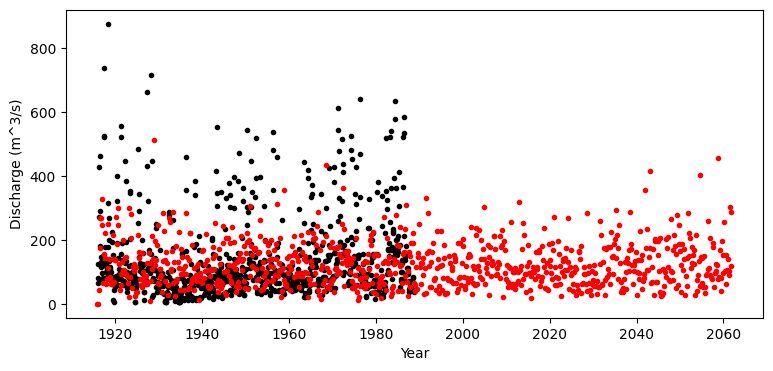

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()

nys['year'] = nys['serMonth']/12+1916

ax.plot(frame.cYr.values, frame.discharge.values, ".k")
ax.plot(nys.year, np.array(predictions)[0][:876], ".r")
#ax.set_ylim(0, 1000)
ax.set_xlabel("Year")
ax.set_ylabel("Discharge (m^3/s)");

And our predictions still seem rather fine which is a good sign, even it it also still low balls the estimates.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


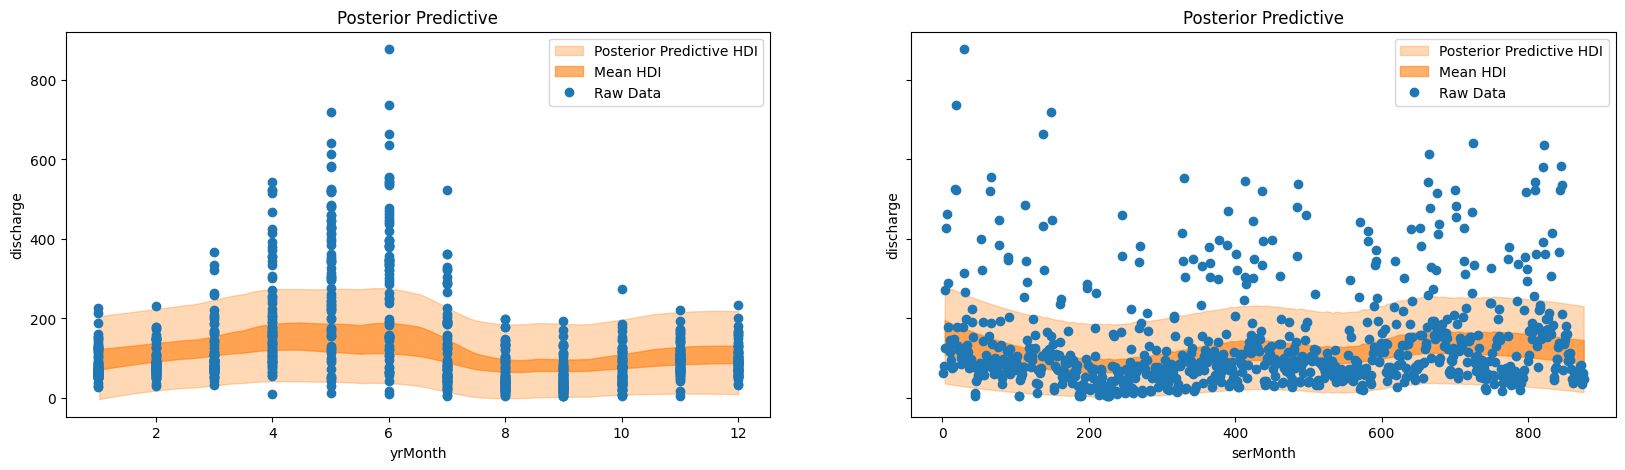

In [ ]:
posterior_mean = idata_lin.posterior["μ"]

μ_hdi = az.hdi(ary=idata_lin, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_lin, group="posterior_predictive", var_names=["y"]
).T


lats = ['yrMonth', 'serMonth']

idx = np.argsort(Xtube)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(20, 5))

for ax, lat in zip([ax1, ax2], lats):
  az.plot_hdi(
      x=Xlin[lat],
      y=pps,
      ax=ax,
      hdi_prob=0.93,
      fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
  )

  az.plot_hdi(
      x=Xlin[lat],
      y=posterior_mean,
      ax=ax,
      hdi_prob=0.74,
      fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
  )
  ax.plot(frame[lat], frame["discharge"], "o", c="C0", label="Raw Data")
  ax.legend(loc="upper right")
  ax.set(
      title="Posterior Predictive",
      xlabel=lat,
      ylabel="discharge",
  );

### Non-Tube w/ Linear nodes?

An Idea I had was to use linear nodes instead of constants on the leaves, since i figured this would give it better prediction capability as it must interpolate or even extrapolate.

In [ ]:
Xlin = frame[['yrMonth', 'serMonth']]
Y = frame['discharge']

In [ ]:
with pm.Model() as model_lin:
    XtubeMut = pm.MutableData("X", Xlin)

    s = pm.HalfNormal('s',2) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", XtubeMut, np.log(Y), m=50, response = 'linear') #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_lin = pm.sample(compute_convergence_checks=False, chains=1) #Chains = 1 supposidly lets it do predictions!?!?

/usr/local/lib/python3.11/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pymc_bart/bart.py:141: UserWarning: Options linear and mix are experimental and still not well tested
Use with caution.
  warnings.warn(


Output()

In [ ]:
pm.sample_posterior_predictive(idata_lin,model_lin, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

<Axes: xlabel='y'>

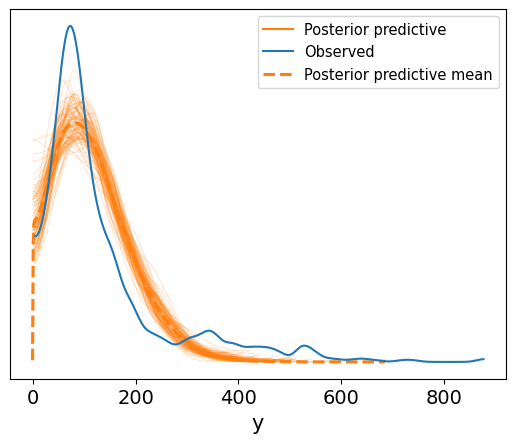

In [ ]:
az.plot_ppc(idata_lin, num_pp_samples=100, colors=["C1", "C0", "C1"])

In [ ]:
pred = np.array(idata_lin.posterior_predictive.to_dataarray())[0] #This keeps crashing the runtime
pred.shape

(1, 1000, 876)

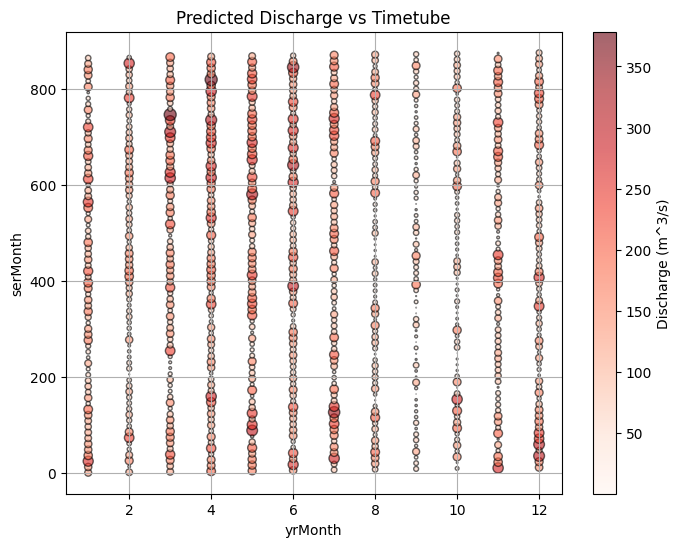

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
k = np.linspace(0, 1, pred.shape[-1])

preds = pred[0][0].reshape(l, 12)
#preds = np.sort(preds, axis = 0)
preds = preds.flatten()

plt.scatter(frame['yrMonth'], frame['serMonth'], s=preds/5, alpha=0.6, c=preds, cmap='Reds', edgecolors="black")
plt.colorbar(label="Discharge (m^3/s)")
plt.xlabel("yrMonth")
plt.ylabel("serMonth")
plt.title("Predicted Discharge vs Timetube")
plt.grid(True)
plt.show()

Heres a visualzition I came up with to replace our circle graph, but its equally useless.

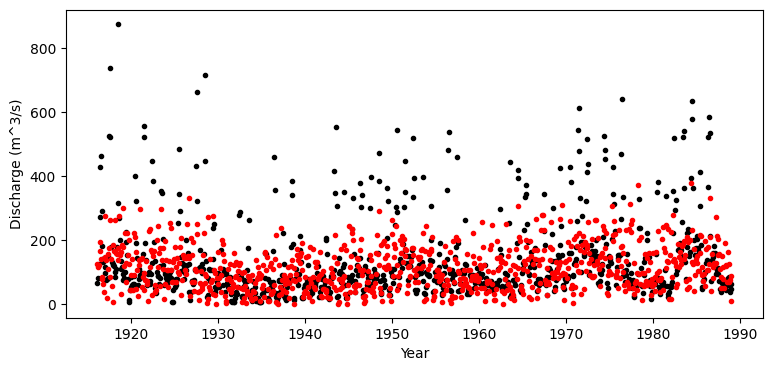

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()

frame['cYr'] = (frame['serMonth'])/12+1916

ax.plot(frame.cYr.values, frame.discharge.values, ".k")
ax.plot(frame.cYr.values, pred[0][0], ".r")
#ax.set_ylim(0, 1000)
ax.set_xlabel("Year")
ax.set_ylabel("Discharge (m^3/s)");

I cant tell if this seems better or worse, but it feels like its got a slightly better distribution?

array([<Axes: xlabel='yrMonth'>, <Axes: xlabel='serMonth'>], dtype=object)

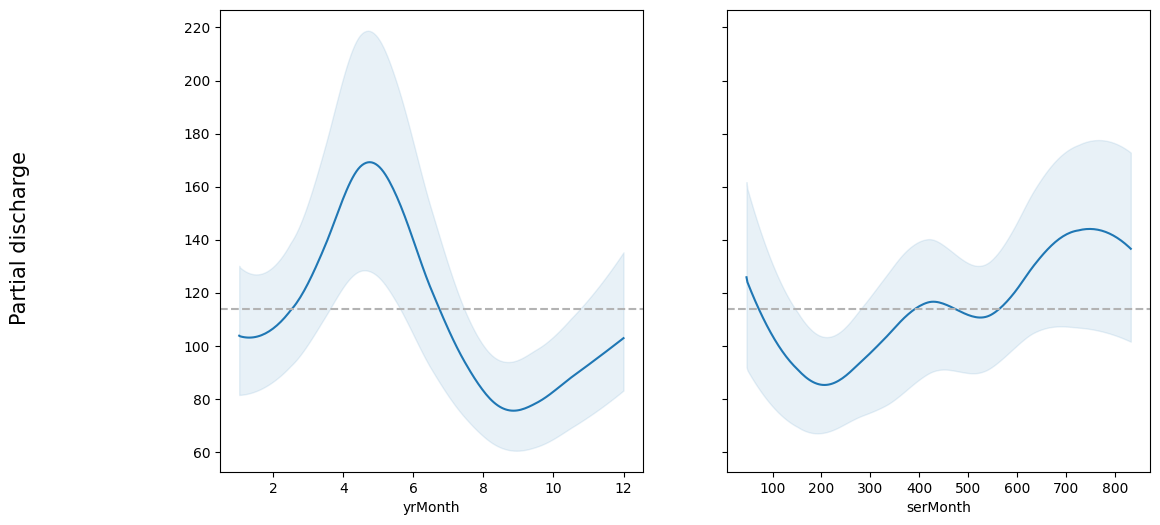

In [ ]:
pmb.plot_pdp(model_lin.μ_, Xlin, Y, grid=(1, 2), func=np.exp, figsize = (12,6))

These still seem rather healthy so I'm happy here

array([<Axes: xlabel='yrMonth'>, <Axes: xlabel='serMonth'>], dtype=object)

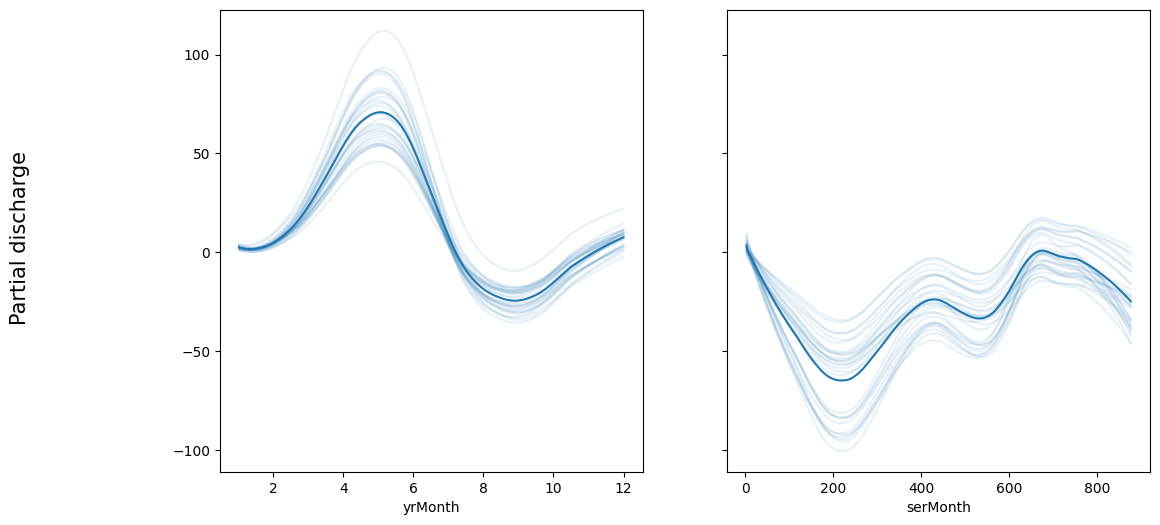

In [ ]:
pmb.plot_ice(model_lin.μ_, Xlin, Y, grid=(1, 2), func=np.exp, figsize = (12,6))

In [ ]:
nys = ConvertYear(np.arange(1916, (1989-1916)*2+1916, 1/6))
with model_lin:
    XtubeMut.set_value(nys)
    #XtubeMut.set_value(ConvertYear(np.arange(1916, 1989, 1/12)))
    rawpreds = pm.sample_posterior_predictive(trace=idata_lin, predictions = True)
    predictions = rawpreds.to_dataframe()

Output()

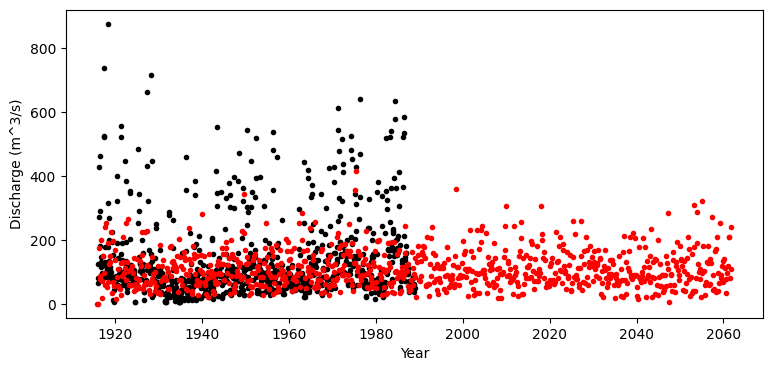

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()

nys['year'] = nys['serMonth']/12+1916

ax.plot(frame.cYr.values, frame.discharge.values, ".k")
ax.plot(nys.year, np.array(predictions)[0][:876], ".r")
#ax.set_ylim(0, 1000)
ax.set_xlabel("Year")
ax.set_ylabel("Discharge (m^3/s)");

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


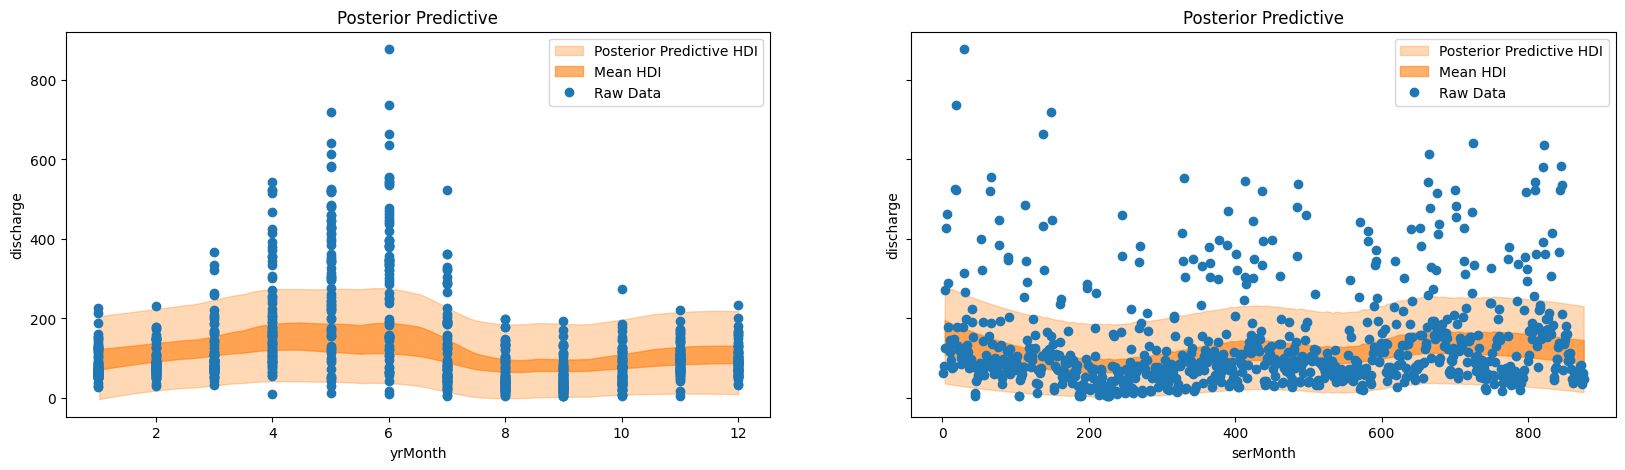

In [ ]:
posterior_mean = idata_lin.posterior["μ"]

μ_hdi = az.hdi(ary=idata_lin, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_lin, group="posterior_predictive", var_names=["y"]
).T


lats = ['yrMonth', 'serMonth']

idx = np.argsort(Xtube)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(20, 5))

for ax, lat in zip([ax1, ax2], lats):
  az.plot_hdi(
      x=Xlin[lat],
      y=pps,
      ax=ax,
      hdi_prob=0.93,
      fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
  )

  az.plot_hdi(
      x=Xlin[lat],
      y=posterior_mean,
      ax=ax,
      hdi_prob=0.74,
      fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
  )
  ax.plot(frame[lat], frame["discharge"], "o", c="C0", label="Raw Data")
  ax.legend(loc="upper right")
  ax.set(
      title="Posterior Predictive",
      xlabel=lat,
      ylabel="discharge",
  );

### Conclusions

 - BART models are a fire and forget model which makes them very easy to use.
 - However because of this it can be difficult to provide the model with context
 - In fact, BART is quite good at learning things, so its not even always nessisary (or its even detrimental) to try and give it context
   - My TemporalTube$^{tm}$ model turned out to hurt our model because we removed some of the linearity of our input space which I think helps make BART not overfit and thus train faster and better.
 - Even tho a linear node shouldve helped the model with predictions, in general it seems to guess fewer extreame discharges than we see observed, so somehting in BART makes conservative guesses.
 - This implementation of BART doesn't like making predictions (out of samples)
 - BART seems to have far less stable predictions compared to a GP or past models, but that might also be due to how volatile my dataset is